<a href="https://www.kaggle.com/code/nedadarbeheshti/acc-grace-lstm?scriptVersionId=146851944" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/grace-satellites-asc-files/SCA1B_2003-10-29_B_02.asc
/kaggle/input/grace-satellites-asc-files/GNV1B_2003-10-29_A_02.asc
/kaggle/input/grace-satellites-asc-files/KBR1B_2008-01-01_X_02.asc
/kaggle/input/grace-satellites-asc-files/KBR1B_2008-01-07_X_02.asc
/kaggle/input/grace-satellites-asc-files/GNV1B_2008-01-01_A_02.asc
/kaggle/input/grace-satellites-asc-files/GNV1B_2005-05-30_A_02.asc
/kaggle/input/grace-satellites-asc-files/GNV1B_2008-12-01_A_02.asc
/kaggle/input/grace-satellites-asc-files/SCA1B_2008-01-01_A_02.asc
/kaggle/input/grace-satellites-asc-files/SCA1B_2008-01-07_B_02.asc
/kaggle/input/grace-satellites-asc-files/KBR1B_2005-05-30_X_02.asc
/kaggle/input/grace-satellites-asc-files/ACC1B_2008-01-07_A_02.asc
/kaggle/input/grace-satellites-asc-files/SCA1B_2003-10-29_A_02.asc
/kaggle/input/grace-satellites-asc-files/KBR1B_2003-10-29_X_02.asc
/kaggle/input/grace-satellites-asc-files/ACC1B_2008-01-07_B_02.asc
/kaggle/input/grace-satellites-asc-files/ACC1B_2005-05-30_A_02

This notebook is based on the LSTM code provided in this article:https://matthewmacfarquhar.medium.com/predicting-airline-passengers-using-lstm-and-tensorflow-ab86347cf318

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt

from keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
real_dir = Path('../input/grace-satellites-asc-files')

In [4]:
#which satellite
sat='B'
#which axis
which_axis='x'

In [5]:
x_axis= pd.read_csv(real_dir/f'ACC1B_2005-05-30_{sat}_02.asc',header=None, sep=' ', skiprows=24,usecols=[2])
y_axis= pd.read_csv(real_dir/f'ACC1B_2005-05-30_{sat}_02.asc',header=None, sep=' ', skiprows=24,usecols=[3])
z_axis= pd.read_csv(real_dir/f'ACC1B_2005-05-30_{sat}_02.asc',header=None, sep=' ', skiprows=24,usecols=[4])

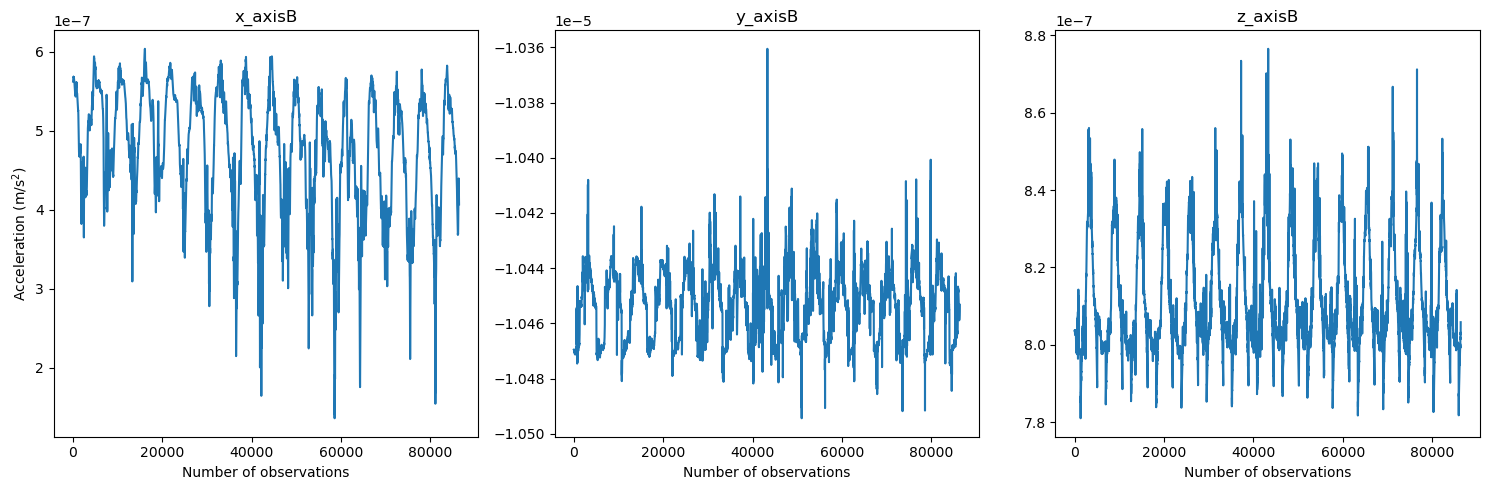

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Plot the first subplot (leftmost)
axes[0].plot(x_axis)
axes[0].set_xlabel('Number of observations')
axes[0].set_ylabel(r'Acceleration (m/s$^2$)')
axes[0].set_title(f'x_axis{sat}')

# Plot the second subplot (middle)
axes[1].plot(y_axis)
axes[1].set_xlabel('Number of observations')
axes[1].set_title(f'y_axis{sat}')

# Plot the third subplot (rightmost)
axes[2].plot(z_axis)
axes[2].set_xlabel('Number of observations')
axes[2].set_title(f'z_axis{sat}')

# Adjust layout and spacing between subplots
plt.tight_layout()

# Display and save the plots
plt.savefig(f'/kaggle/working/acc_real{sat}.png', format='png', dpi=300)


Remove outliers

In [7]:
def remove_outliers(axis):
    q1 = np.percentile(axis, 25)
    q3 = np.percentile(axis, 75)
    IQR = q3 - q1
    max_limit = q3 + (1.5 * IQR)
    min_limit = q1 - (1.5 * IQR)
    
    outliers = np.logical_or(axis > max_limit, axis < min_limit)
    cleaned_data = axis[~outliers]
    
    return cleaned_data

In [8]:
cleaned_x_axis = remove_outliers(x_axis.values)
cleaned_y_axis = remove_outliers(y_axis.values)
cleaned_z_axis = remove_outliers(z_axis.values)

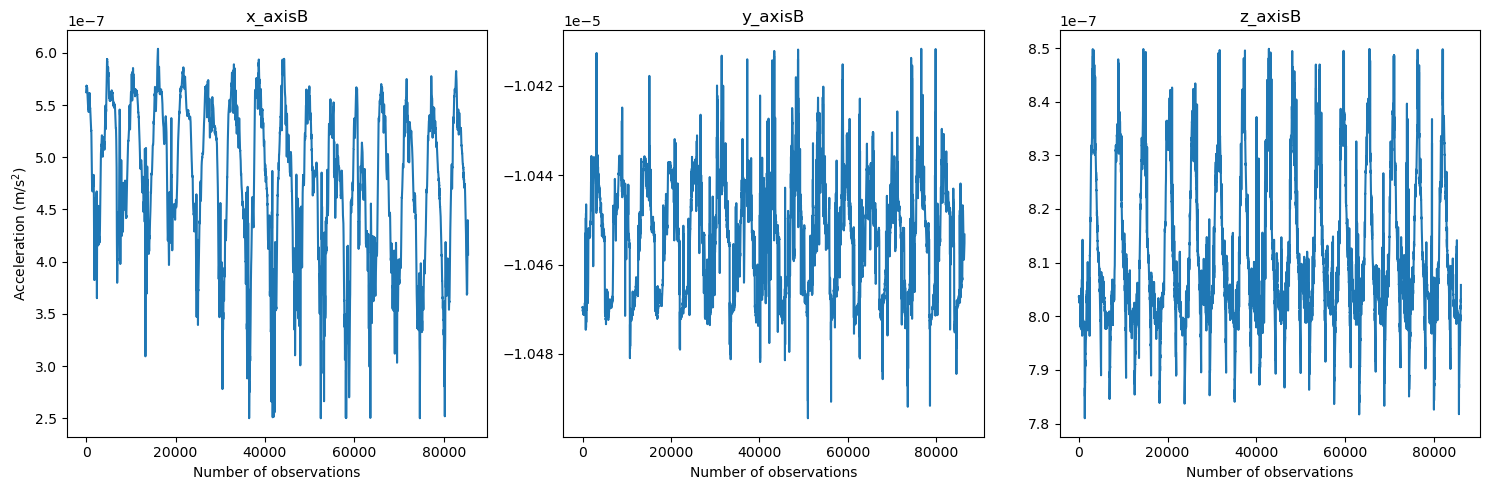

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Plot the first subplot (leftmost)
axes[0].plot(cleaned_x_axis)
axes[0].set_xlabel('Number of observations')
axes[0].set_ylabel(r'Acceleration (m/s$^2$)')
axes[0].set_title(f'x_axis{sat}')

# Plot the second subplot (middle)
axes[1].plot(cleaned_y_axis)
axes[1].set_xlabel('Number of observations')
axes[1].set_title(f'y_axis{sat}')

# Plot the third subplot (rightmost)
axes[2].plot(cleaned_z_axis)
axes[2].set_xlabel('Number of observations')
axes[2].set_title(f'z_axis{sat}')

# Adjust layout and spacing between subplots
plt.tight_layout()

# Display and save the plots
plt.savefig(f'/kaggle/working/acc_cleaned{sat}.png', format='png', dpi=300)

Normalizing the data

In [10]:
# choose one
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
#standard scaler
#from sklearn.preprocessing import RobustScaler
#scaler = RobustScaler()

In [11]:
cleaned_x_axis = scaler.fit_transform(cleaned_x_axis.reshape(-1, 1))
cleaned_y_axis = scaler.fit_transform(cleaned_y_axis.reshape(-1, 1))
cleaned_z_axis = scaler.fit_transform(cleaned_z_axis.reshape(-1, 1))

downsample the data

In [12]:
downrate=10
if which_axis == 'x':
    df= cleaned_x_axis[0:len(cleaned_x_axis):downrate]
elif which_axis == 'y':
    df= cleaned_y_axis[0:len(cleaned_y_axis):downrate]
elif which_axis == 'z':
    df= cleaned_z_axis[0:len(cleaned_z_axis):downrate]
else:
    print("Invalid axis selection.")
    exit()
df.shape

(8545, 1)

In [13]:
train_size = int(len(df) * 0.7)
train, test = df[0:train_size], df[train_size:]

In [14]:
def create_dataset(dataset, look_back=1):
    X,Y = [], []
    for i in range(len(dataset)-look_back-1):
        X.append(dataset[i:(i+look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [15]:
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [16]:
model = Sequential()
model.add(LSTM(8, input_shape=(1, look_back)))
model.add(Dense(10))
model.add(Dense(32))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 768       
                                                                 
 dense (Dense)               (None, 10)                90        
                                                                 
 dense_1 (Dense)             (None, 32)                352       
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,243
Trainable params: 1,243
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=["mae"])
history = model.fit(trainX,trainY, epochs=300, batch_size =8, verbose=0, validation_split= 0.15)

In [18]:
# Set the range for the x-axis and y-axis
y_min = 0.001
y_max = .014

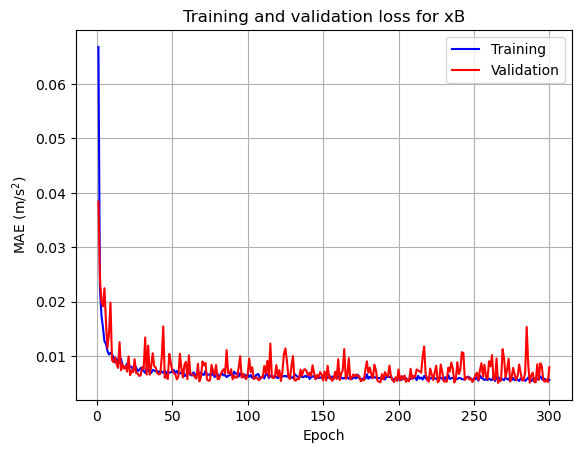

In [19]:
loss1 = history.history["mae"] 
val_loss = history.history["val_mae"] 
epochs = range(1, len(loss1) + 1) 
plt.figure()
plt.plot(epochs, loss1, "b", label="Training")
plt.plot(epochs, val_loss, "r", label="Validation")
#plt.ylim(y_min, y_max)
plt.xlabel('Epoch')
plt.ylabel(r'MAE (m/s$^2$)')
plt.title(f"Training and validation loss for {which_axis}{sat}")
plt.legend()
plt.grid(True)
plt.savefig(f'/kaggle/working/loss{which_axis}{sat}.png', format='png', dpi=300)

In [20]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.11f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.11f RMSE' % (testScore))

80/80 [==============================] - 0s 1ms/step
Train Score: 0.00000000062 RMSE
Test Score: 0.00000000059 RMSE


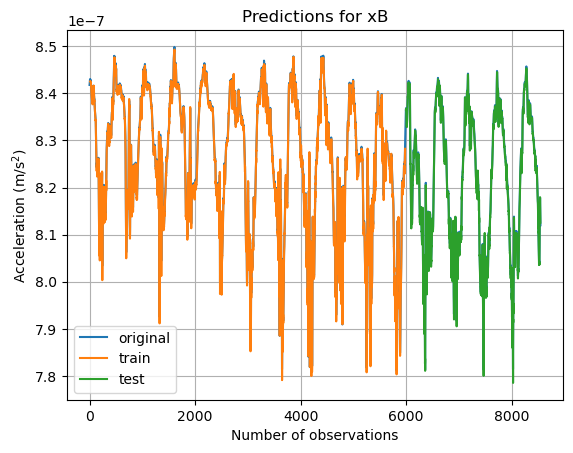

In [21]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :] = testPredict# plot baseline and predictions
plt.plot(scaler.inverse_transform(df), label='original')
plt.plot(trainPredictPlot, label='train')
plt.plot(testPredictPlot, label='test')
plt.xlabel('Number of observations')
plt.ylabel(r'Acceleration (m/s$^2$)')
plt.title(f"Predictions for {which_axis}{sat}")
plt.grid(True)
plt.legend()
plt.savefig(f'/kaggle/working/train_test{which_axis}{sat}.png', format='png', dpi=300)